# Figure 2.5

Pairwise comparisons between in vitro and in vivo


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import warnings
import os
import functools
import upsetplot

warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

In [45]:
master = pd.read_csv('master_table_min50_control_mean_invitro.csv')

master_targ = master[master['classification']=='targeting guide']

hh = []
for i in master_targ['HGVSp_h']:
    if type(i)==str:
        i2 = i.replace('delins', '')
        hh.append(i2)
    else:
        hh.append('Non-coding')

master_targ['HGVSp_h']=hh
#master_targ['HGVSp_h'] = [i.replace('delins', '') for i in master_targ['HGVSp_h'] if type(i)==str]

#and add TSG/Oncogene info

cosmic = pd.read_csv('source_data/Census_allSun Nov 17 02_26_47 2024.csv').fillna('Undefined')


t_dict = {'TSG':'TSG', 'TSG, fusion':'TSG', 'Undefined':'Undefined', 'fusion':'Undefined', 'oncogene':'Oncogene',
       'oncogene, TSG':'Oncogene/TSG', 'oncogene, TSG, fusion':'Oncogene/TSG', 'oncogene, fusion': 'Oncogene'}

gene_type = []
for i, val in master_targ.iterrows():
    v = val['gene_name_h']
    subset = cosmic[cosmic['Gene Symbol']==v]
    if len(subset)==0:
        gene_type.append('Undefined')
    else:
        v2 = subset['Role in Cancer'].values[0]

        gene_type.append(t_dict[v2])

master_targ['Role in Cancer']=gene_type

In [46]:
samples = ['LFC_In Vitro D15', 'LFC_Spleen']

for idx, val in enumerate(samples):

    nums = [0,1]
    nums.remove(idx)

    considering = master_targ[val]
    avgs = np.average(master_targ[[samples[i] for i in nums]], axis=1)

    delta = considering-avgs
    master_targ[f"d_{val.split('_')[1]}"] = delta

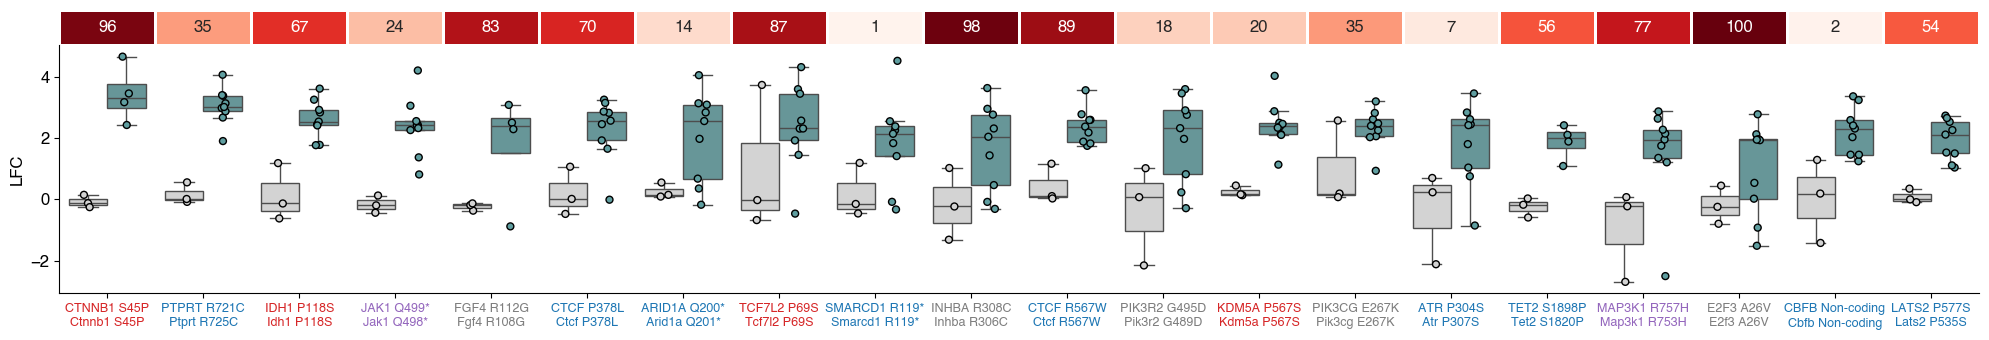

In [51]:
#bone/spleen specific
t = master_targ.sort_values(by='d_Spleen', ascending=False)
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<0) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
t1 = t[(t['LFC_Spleen']>1)  & (t['LFC_In Vitro D15']<0.25) & (t['LFC_In Vitro D15']>-0.25) & (t['target_base_edit_perc']>=1) & (t['FDR_Spleen']<.05)][:20]


#t1 = t[:10]

#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<-0.5) & (t['LFC_In Vitro D15']<0.05) & (t['target_base_edit_perc']>=1)][:10]


#gRNAs_UMAP.append(list(t1['gRNA_id']))

samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

samples2 = ['In Vitro D15', 'Spleen',] #, 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(20,3.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f',vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=True, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=9)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

ax[1].get_legend().remove()
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#fig.savefig('figures/spleen_neutralv2.pdf')

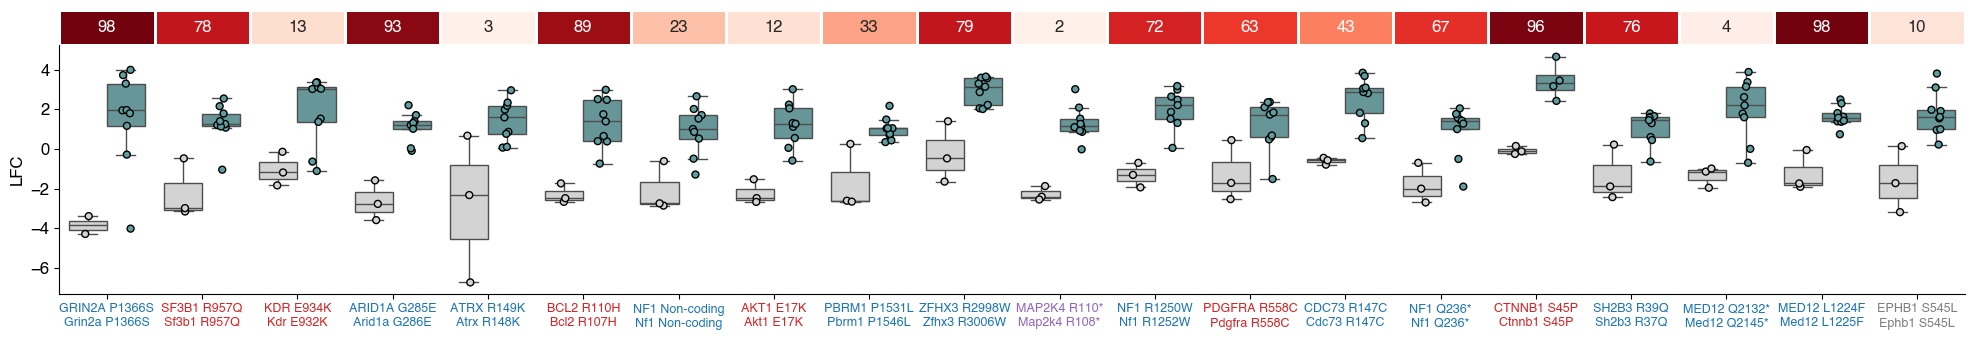

In [52]:
t = master_targ.sort_values(by='d_Spleen', ascending=False)
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<0) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
t1 = t[(t['LFC_Spleen']>1)  & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:20]


#t1 = t[:10]

#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<-0.5) & (t['LFC_In Vitro D15']<0.05) & (t['target_base_edit_perc']>=1)][:10]


#gRNAs_UMAP.append(list(t1['gRNA_id']))

samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

samples2 = ['In Vitro D15', 'Spleen',] #, 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(20,3.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f',vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=True, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=9)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

ax[1].get_legend().remove()

fig.tight_layout()
fig.subplots_adjust(hspace=0)
#fig.savefig('figures/spleen_nonneutral.pdf')

In [54]:
samples = ['LFC_In Vitro D15', 'LFC_Bone']

for idx, val in enumerate(samples):

    nums = [0,1]
    nums.remove(idx)

    considering = master_targ[val]
    avgs = np.average(master_targ[[samples[i] for i in nums]], axis=1)

    delta = considering-avgs
    master_targ[f"d_{val.split('_')[1]}"] = delta

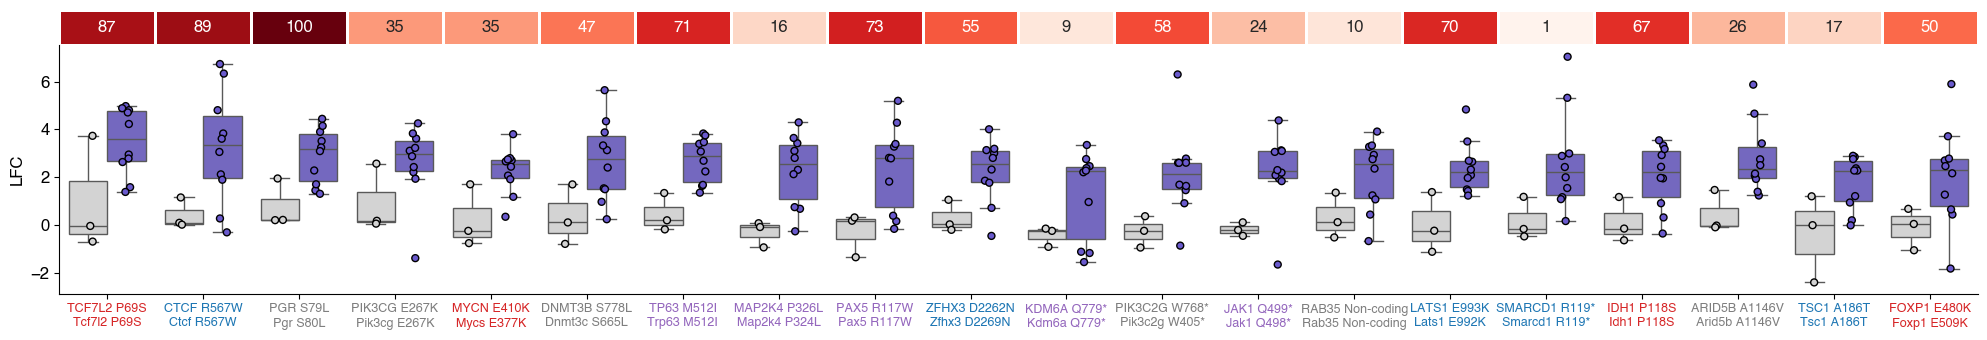

In [55]:
#bone/spleen specific
t = master_targ.sort_values(by='d_Bone', ascending=False)
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<0) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
t1 = t[(t['LFC_Bone']>1)  & (t['LFC_In Vitro D15']<0.25) & (t['LFC_In Vitro D15']>-0.25) & (t['target_base_edit_perc']>=1) & (t['FDR_Bone']<.05)][:20]


#t1 = t[:10]

#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<-0.5) & (t['LFC_In Vitro D15']<0.05) & (t['target_base_edit_perc']>=1)][:10]


#gRNAs_UMAP.append(list(t1['gRNA_id']))

#samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

samples2 = ['In Vitro D15', 'Bone',] #, 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(20,3.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

palette = ['lightgrey','slateblue','lightcoral', '#ED6A50',]


sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f',vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=True, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=9)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

ax[1].get_legend().remove()

fig.tight_layout()
fig.subplots_adjust(hspace=0)
#fig.savefig('figures/bone_neutralv2.pdf')

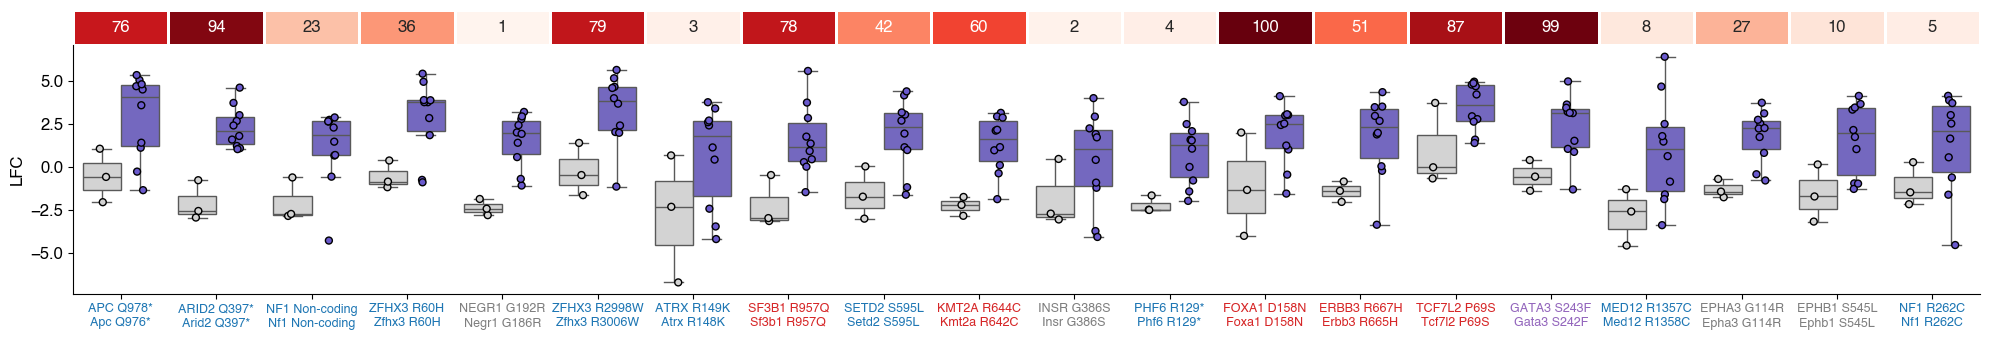

In [56]:
#bone/spleen specific
t = master_targ.sort_values(by='d_Bone', ascending=False)
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<0) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
t1 = t[(t['LFC_Bone']>1)  & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1) & (t['FDR_Bone']<.05)][:20]


#t1 = t[:10]

#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<-0.5) & (t['LFC_In Vitro D15']<0.05) & (t['target_base_edit_perc']>=1)][:10]


#gRNAs_UMAP.append(list(t1['gRNA_id']))

#samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

samples2 = ['In Vitro D15', 'Bone',] #, 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(20,3.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

palette = ['lightgrey','slateblue','lightcoral', '#ED6A50',]


sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f',vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=True, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=9)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

ax[1].get_legend().remove()

fig.tight_layout()
fig.subplots_adjust(hspace=0)
#fig.savefig('figures/bone_nonneutral.pdf')

In [57]:
samples = ['LFC_In Vitro D15', 'LFC_Meninges']

for idx, val in enumerate(samples):

    nums = [0,1]
    nums.remove(idx)

    considering = master_targ[val]
    avgs = np.average(master_targ[[samples[i] for i in nums]], axis=1)

    delta = considering-avgs
    master_targ[f"d_{val.split('_')[1]}"] = delta

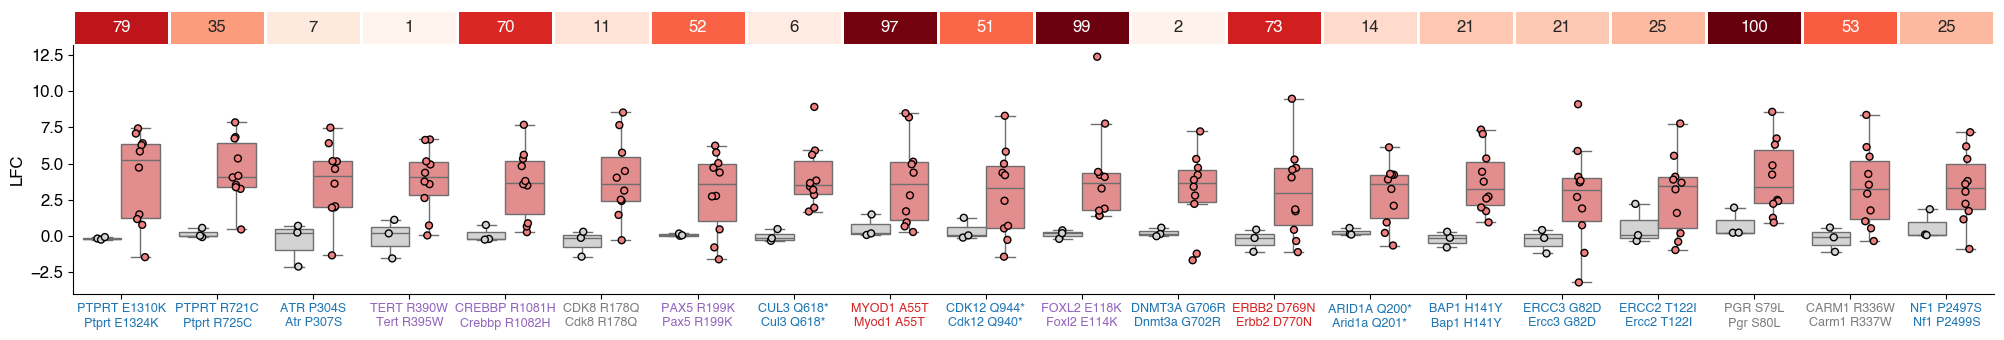

In [58]:
#bone/spleen specific
t = master_targ.sort_values(by='d_Meninges', ascending=False)
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<0) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
t1 = t[(t['LFC_Meninges']>1)  & (t['LFC_In Vitro D15']<0.25) & (t['LFC_In Vitro D15']>-0.25) & (t['target_base_edit_perc']>=1) & (t['FDR_Meninges']<.05)][:20]


#t1 = t[:10]

#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<-0.5) & (t['LFC_In Vitro D15']<0.05) & (t['target_base_edit_perc']>=1)][:10]


#gRNAs_UMAP.append(list(t1['gRNA_id']))

#samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

samples2 = ['In Vitro D15', 'Meninges',] #, 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(20,3.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

palette = ['lightgrey','lightcoral', '#ED6A50',]


sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f',vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=True, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=9)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

ax[1].get_legend().remove()

fig.tight_layout()
fig.subplots_adjust(hspace=0)
#fig.savefig('figures/meninges_neutralv2.pdf')

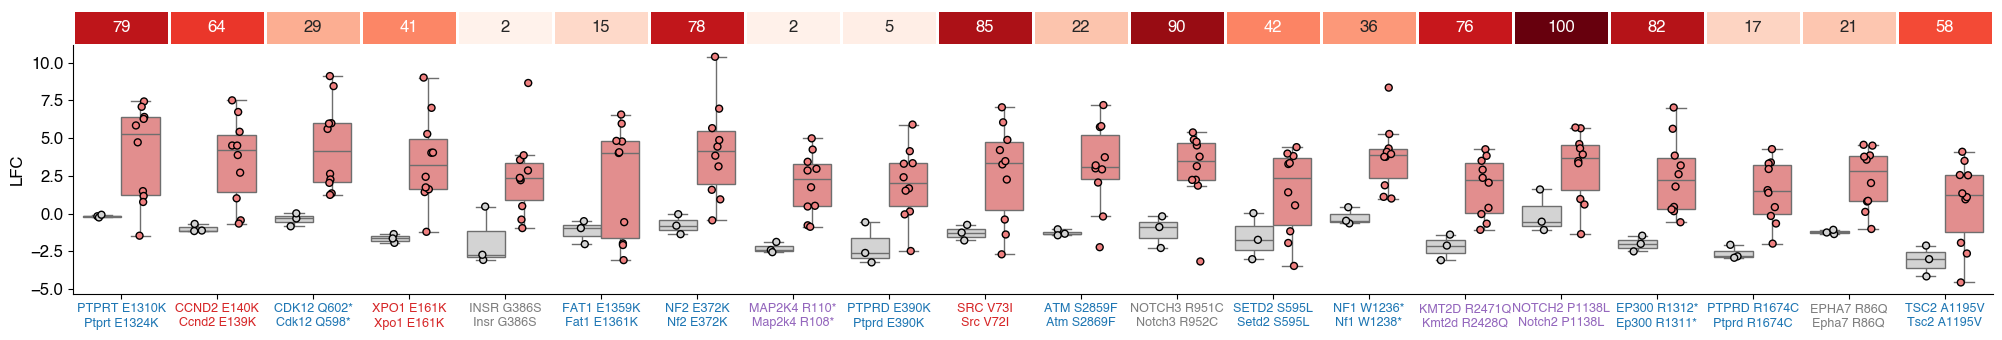

In [59]:
#bone/spleen specific
t = master_targ.sort_values(by='d_Meninges', ascending=False)
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<0) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
t1 = t[(t['LFC_Meninges']>1)  & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1) & (t['FDR_Meninges']<.05)][:20]


#t1 = t[:10]

#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<-0.5) & (t['LFC_In Vitro D15']<0.05) & (t['target_base_edit_perc']>=1)][:10]


#gRNAs_UMAP.append(list(t1['gRNA_id']))

#samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

samples2 = ['In Vitro D15', 'Meninges',] #, 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(20,3.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

palette = ['lightgrey','lightcoral', '#ED6A50',]


sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, fmt='.0f',vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=True, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=9)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

ax[1].get_legend().remove()

fig.tight_layout()
fig.subplots_adjust(hspace=0)
#fig.savefig('figures/meninges_nonneutralv2.pdf')